In [1]:
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

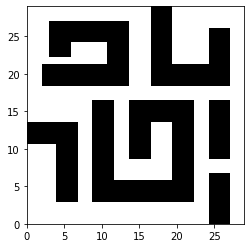

In [2]:
# Load obstacle data
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_states/motion_planning/maps/mapA.png'
mapImg = cv2.imread(filename, 0)
blurImg = cv2.blur(mapImg, ksize=(3,3))

occGrid = np.clip(mapImg, 0, 1)
inflatedGrid = np.floor(blurImg / 255)
gridSize = occGrid.shape[0]

plt.imshow(inflatedGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
plt.show()

In [3]:
# define planning problem

def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return inflatedGrid[v,u] > 0


def problemDef():
    # construct the state space we are planning in
    #space = ob.DubinsStateSpace(turningRadius=0.05)
    space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # define a simple setup class
    ss = og.SimpleSetup(space)
    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))

    si = ss.getSpaceInformation()
    planner = og.RRTstar(si)
    ss.setPlanner(planner)

    return ss


def plan(planObj, initState, goalState):

    #space = ob.DubinsStateSpace(turningRadius=0.05)
    space = ob.SE2StateSpace()
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(4.0)
    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), epsilon=0.2)
    orTerminationCondition = ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition)

    solved = planObj.solve(orTerminationCondition)
    if solved:
        planObj.simplifySolution()



In [ ]:
# generate planning data, car scenario

nData = 10 # number of plans to generate

minDistThreshold = 0.5 # minimum distance threshold betwen start/goal

trajSamples = np.zeros(shape=(1, 4)) # x, y, xdot, ydot
newInitData = np.zeros(shape=(1, 4)) # x, y, xdot, ydot
newGoalData = np.zeros(shape=(1, 4))

planObj = problemDef()

plotPaths = True
i = 0 
nPlans = 0 # number of completed plans
while nPlans < nData:

    start = np.array([0, 0, 0]) # x, y, yaw
    goal  = np.copy(start)
    ux = 0; vx = 0; uy = 0; vy = 0
    
    while True:
        start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
        goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
        ux = int(np.floor(start[0] * gridSize)) # right pointing image axis
        vx = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
        uy = int(np.floor(goal[0] * gridSize)) # right pointing image axis
        vy = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
        if np.linalg.norm(start[:2] - goal[:2]) > minDistThreshold and inflatedGrid[vx,ux] > 0 and inflatedGrid[vy,uy] > 0:
            break

    plan(planObj, start, goal)

    if planObj.getProblemDefinition().hasExactSolution():

        sol = np.loadtxt(StringIO(planObj.getSolutionPath().printAsMatrix()))
        dxdy = np.concatenate((sol[1:,0:2] - sol[:-1,0:2], (goal[:2] - sol[-1,0:2]).reshape(1, 2)), axis=0)
        xydot = dxdy / np.linalg.norm(dxdy, axis=1).reshape(sol.shape[0],1)

        if np.linalg.norm(sol[0, :2] - start[:2]) < 0.01:
            sol = sol[1:]
            xydot = xydot[1:]
        if np.linalg.norm(sol[-1, :2] - goal[:2]) < 0.01:
            sol = sol[:-1]
            xydot = xydot[:-1]

        nSamples = sol.shape[0]

        if nSamples > 0:
            start_dxdy = sol[0, :2] - start[:2]; goal_dxdy = goal[:2] - sol[-1, :2]
            start_xydot = start_dxdy / np.linalg.norm(start_dxdy); goal_xydot = goal_dxdy / np.linalg.norm(goal_dxdy)

            trajSamples = np.vstack((trajSamples, np.hstack((sol[:, 0:2], xydot)))) # x, y, xdot, ydot
            newInitData = np.vstack((newInitData, np.tile(np.append(start[0:2], start_xydot), reps=(nSamples, 1)))) # x, y, xdot, ydot
            newGoalData = np.vstack((newGoalData, np.tile(np.append(goal[0:2], goal_xydot), reps=(nSamples, 1)))) # x, y, xdot, ydot
            
            if plotPaths:
                fig, ax = plt.subplots()
                ax.quiver(newInitData[-1, 0] * gridSize, newInitData[-1, 1] * gridSize, newInitData[-1, 2], newInitData[-1, 3], color="red", scale=8.0, width=0.015)
                ax.quiver(newGoalData[-1, 0] * gridSize, newGoalData[-1, 1] * gridSize, newGoalData[-1, 2], newGoalData[-1, 3], color="blue", scale=8.0, width=0.015)
                ax.quiver(sol[:, 0] * gridSize, sol[:, 1] * gridSize, xydot[:, 0], xydot[:, 1], color="green", scale=8.0, width=0.015, alpha=0.9)
                ax.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
                plt.show()

            nPlans += 1
            if nPlans % 500 == 0:
                newData = np.concatenate((trajSamples, newInitData, newGoalData), axis=1)[1:]
                np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data/pathDataDifficult_n' + str(nPlans), newData, delimiter=',', fmt='%1.6f')
  
    planObj.clear()
    i += 1  

newData = np.concatenate((trajSamples, newInitData, newGoalData), axis=1)[1:]
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data/pathDataDifficult_n' + str(nPlans), newData, delimiter=',', fmt='%1.6f')
